In [1]:
import sympy as sp
import numpy as np
from sympy import *
init_printing()

# Initializing

In [6]:
# Coordinates
r, theta, phi = symbols('r, theta, phi')
coords = [r, theta, phi]


# Horizon function
#h = Function('h')(theta, phi)
h = Function('h')(theta)


# Additional symbols
N = symbols('N')
M = symbols('M')
R = symbols('R')


# ADM 3+1 components
alpha = Function('alpha')(r, theta, phi)   # lapse function
alpha = (1-M/(2*r)) / (1+M/(2*r))
#alpha = 1

beta = Array([0,0,0])                       # Shift vector

psi = Function('psi')(r, theta, phi)       # Conformal factor
psi = 1 + M/(2*r)
#psi = 1
psi4 = psi**4




eta = diag(1, r**2, (r*sin(theta))**2)
eta_inv = eta**(-1)

# Normal vectors

Normal vectors defined by $$n^{\mu} = \frac{1}{\alpha} (1, -\beta^i)$$ such that
$$n^i = -\frac{1}{\alpha} \beta^i$$ and $$n_i = \gamma_{ij}n^j = \psi^4\eta_{ij}n^j = -\psi^4\frac{1}{\alpha}\eta_{ij}\beta^j$$

In [7]:
'''
Define normal vectors
'''

# Index up
def norm_up(alpha, beta, coords):
    dim = len(coords)
    n_up = sp.MutableDenseNDimArray.zeros(dim)
    for i in range(dim):
        n_up[[i]] = - 1/alpha * beta[i]
    return n_up

# Index down
def norm_down(alpha, beta, psi4, eta, coords):
    dim = len(coords)
    n_down = sp.MutableDenseNDimArray.zeros(dim)
    for i in range(dim):
        n_down[[i]] = - psi4 * 1/alpha * sum(eta[i, j] * beta[j] for j in range(dim))
    return n_down

    
#n_up = norm_up(alpha, beta, coords)
#n_down = norm_down(alpha, beta, psi4, eta, coords)

#display(n_up, n_down)

# Christoffel symbols

In the conformally flat assumption $$\gamma^{ij} = \psi^{-4} \eta^{ij}$$ the Christoffel symbols become
$$\begin{aligned}
\Gamma^i_{jk} &= \frac{1}{2} \gamma^{ia} (\partial_j \gamma_{ka} + \partial_k \gamma_{ja} - \partial_a \gamma_{jk}) \\[5pt]
&= \frac{1}{2} \psi^{-4} \eta^{ia} \left[\partial_j(\psi^4\eta_{nk}) + \partial_k(\psi^4\eta_{ja}) - \partial_a(\psi^4\eta_{jk})\right] \\[5pt]
&= \frac{1}{2} \eta^{ia} (\partial_j \eta_{ka} + \partial_k \eta_{ja} - \partial_a \eta_{jk}) + \frac{1}{2} \psi^{-4} \eta^{ia} (\eta_{ka} \partial_j \psi^4 + \eta_{ja} \partial_k \psi^4 - \eta_{jk} \partial_a \psi^4)
\end{aligned}$$

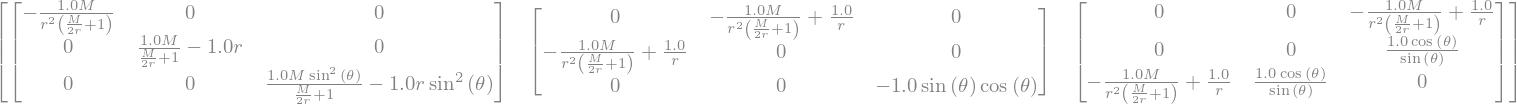

In [8]:
'''
Christoffel symbols
'''

def christoffel_symbols(psi4, eta, eta_inv, coords):
    n = len(coords)
    Gamma = sp.MutableDenseNDimArray.zeros(n, n, n)
    
    for i in range(n):
        for j in range(n):
            for k in range(n):
                Gamma[i, j, k] = (0.5 * sum([eta_inv[i, a] * (sp.diff(eta[k, a], coords[j]) + 
                                                           sp.diff(eta[j, a], coords[k]) - 
                                                           sp.diff(eta[j, k], coords[a])) for a in range(n)]) +
                                 0.5 * 1/psi4 * sum([eta_inv[i, a] * (eta[k, a] * sp.diff(psi4, coords[j]) + 
                                                                       eta[j, a] * sp.diff(psi4, coords[k]) - 
                                                                       eta[j, k] * sp.diff(psi4, coords[a])) for a in range(n)]))
    return Gamma


# Calculate the Christoffel symbols
#christoffel = christoffel_symbols(psi4, eta, eta_inv, coords)

#display(christoffel)

# Vector s

Vector $s$ given by $$s_i = \lambda (1, -\partial_{\theta}h, \partial_{\phi}h)$$ such that $$s^i = \gamma^{ij} s_j = \psi^4 \eta^{ij} s_j \quad \Leftrightarrow \quad s^i = \lambda \psi^4 \left(1, -\frac{1}{r^2} \partial_{\theta}h, -\frac{1}{r^2 \sin^2{\theta}} \partial_{\phi}h\right)$$ and $$1 = s_i s^i = \lambda^2 \psi^4 \left(1 + \frac{1}{r^2} (\partial_{\theta}h)^2 + \frac{1}{r^2 \sin^2{\theta}} (\partial_{\phi}h)^2\right)$$

In [9]:
'''
Spacelike outward-pointing vector s
'''

def s_norm(h, psi4, coords, eta_inv):
    n = len(coords)
    #s = Array([1, 0, 0])
    s = Array([1, -diff(h, theta), 0])
    #s = Array([1, -diff(h, theta), -diff(h, phi)])
    s_inv = sp.MutableDenseNDimArray.zeros(n)
    for i in range(n):
        s_inv[[i]] = psi4 * sum([eta_inv[i, j] * s[j] for j in range(n)])
    norm = 1 / (sum(s[i] * s_inv[i] for i in range(n)))
    N = sp.sqrt(norm)
    s_norm = N * s
    s_inv_norm = N * s_inv
    return s_inv_norm


#s_inv_norm = s_norm(h, psi4, coords, eta_inv)

# Extrinsic curvature

Calculating from the formula $$K_{ij} = \gamma_i^a \gamma_j^b \nabla_a n_b$$ where $$\gamma_i^a = \delta_i^a + n^a n_i$$

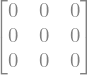

In [10]:
'''
Extrinsic Curvature
'''

def extrinsic_curvature(n_up, n_down, christoffel, coords):
    n = len(coords)
    delta = eye(n)
    K = sp.MutableDenseNDimArray.zeros(n, n)
    for i in range(n):
        for j in range(n):
            K[i, j] = sum(sum((delta[i, a] + n_up[a]*n_down[i]) * (delta[j, b] + n_up[b]*n_down[j]) * (diff(n_down[b], coords[a]) -
                      sum(christoffel[k, a, b]*n_down[k] for k in range(n))) for b in range(n)) for a in range(n))
    return K


#cur = extrinsic_curvature(n_up, n_down, christoffel, coords)
#display(sp.simplify(cur))

# Expansion equation

The expansion equation is $$\Theta = \nabla_i s^i + s^i s^j K_{ij} - K = 0$$
We assume maximal slicing condition such that $$K = 0$$

In [11]:
'''
Expansion function
'''

# First term
def cov_derivative(christoffel, s, coords):
    n = len(coords)
    cov_dev = sum(diff(s[i], coords[i]) for i in range(n)) + sum(sum(christoffel[i, i, j] * s[j] for j in range(n)) for i in range(n))
    return cov_dev

# Second term
def curv(ext_curv, s, coords):
    n = len(coords)
    curv = sum(sum(ext_curv[i, j] * s[i] * s[j] for j in range(n)) for i in range(n))
    return curv

# Full equation
def expansion(christoffel, s, ext_curv, coords):
    return (cov_derivative(christoffel, s, coords) + curv(ext_curv, s, coords))

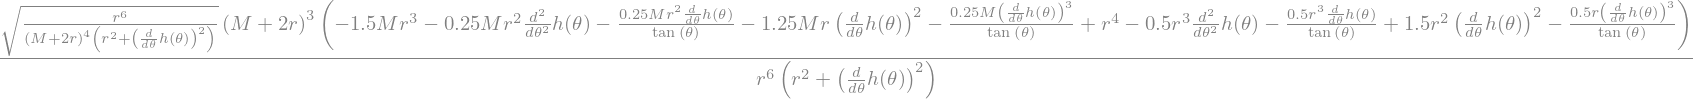

In [13]:
test = expansion(christoffel, s_inv_norm, cur, coords)
display(sp.simplify(test))

***

***

***

***